# Exploring Convolutional Layers Through Data and Experiments

## Dataset Exploration (EDA)

In this notebook, we explore the Fashion-MNIST dataset as a preparation step for designing and analyzing convolutional neural network (CNN) architectures.

The goal of this section is not exhaustive statistical analysis, but rather understanding the **structure, dimensionality, and suitability** of the dataset for convolutional layers.


In [3]:
%pip install torchvision

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   --------- ------------------------------ 1.0/4.3 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 13.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## 1. Dataset Exploration (EDA)

In [5]:
# Transform: convert images to tensors and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

# Load training and test datasets
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)



100.0%
100.0%
100.0%
100.0%


In [6]:
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

sample_image, sample_label = train_dataset[0]
print("Image shape:", sample_image.shape)
print("Label:", sample_label)

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Label: 9


In [7]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Classes:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")


Classes:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


In [8]:
labels = [label for _, label in train_dataset]
labels = np.array(labels)

unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"{class_names[u]}: {c} samples")


T-shirt/top: 6000 samples
Trouser: 6000 samples
Pullover: 6000 samples
Dress: 6000 samples
Coat: 6000 samples
Sandal: 6000 samples
Shirt: 6000 samples
Sneaker: 6000 samples
Bag: 6000 samples
Ankle boot: 6000 samples


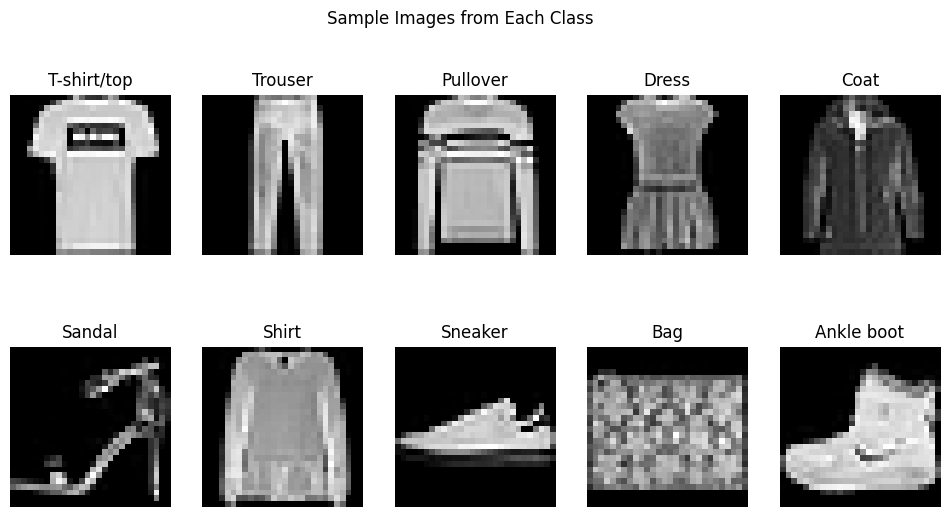

In [9]:
plt.figure(figsize=(12, 6))

for i in range(10):
    idx = np.where(labels == i)[0][0]
    image, label = train_dataset[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()


## Baseline Model: Fully Connected Neural Network (MLP)

Before introducing convolutional layers, we implement a baseline neural network composed only of fully connected layers.

This model ignores the spatial structure of images by flattening them into 1D vectors.  
Its purpose is to serve as a **reference point** for later comparison with convolutional architectures.


In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [11]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
model = BaselineMLP()

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)


Total parameters: 109386


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    history = []

    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        history.append((running_loss, accuracy))

        print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Accuracy={accuracy:.4f}")

    return history


In [16]:
history = train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    epochs=5
)


Epoch 1: Loss=484.2699, Accuracy=0.8131
Epoch 2: Loss=354.3050, Accuracy=0.8613
Epoch 3: Loss=317.1176, Accuracy=0.8759
Epoch 4: Loss=296.4663, Accuracy=0.8818
Epoch 5: Loss=277.6417, Accuracy=0.8901


In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

test_accuracy = evaluate_model(model, test_loader)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8681


## Convolutional Architecture Design

In this section, we design a convolutional neural network (CNN) from scratch.
The goal is not depth or state-of-the-art performance, but a **clear and intentional architectural design** that exploits the spatial structure of image data.

Each design choice is explicitly justified in terms of inductive bias, parameter efficiency, and learning behavior.


### Design Principles

The following principles guide the architecture design:

- Preserve spatial information in early layers.
- Use small kernels to capture local patterns such as edges and textures.
- Gradually increase feature depth to learn more abstract representations.
- Reduce spatial resolution only after meaningful features are extracted.
- Keep the architecture shallow and interpretable.


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)

        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


### Dimensionality Flow

Input image: 28 × 28 × 1

After Conv1 (3×3, padding=1):  
→ 28 × 28 × 16

After MaxPooling (2×2):  
→ 14 × 14 × 16

After Conv2 (3×3, padding=1):  
→ 14 × 14 × 32

After MaxPooling (2×2):  
→ 7 × 7 × 32

Flatten:  
→ 1568 features


In [20]:
cnn_model = SimpleCNN()

total_params_cnn = sum(p.numel() for p in cnn_model.parameters())
print("Total CNN parameters:", total_params_cnn)


Total CNN parameters: 206922


## Architectural Justification

### Number of Convolutional Layers
Two convolutional layers are used to progressively extract low-level and mid-level features.
A deeper architecture is unnecessary for this dataset size and resolution.

### Kernel Sizes
A 3×3 kernel is chosen to capture local spatial patterns while keeping the number of parameters low.
Stacking small kernels increases effective receptive field without losing resolution.

### Stride and Padding
Stride of 1 preserves spatial resolution.
Padding of 1 ensures feature maps maintain the same spatial dimensions after convolution.

### Activation Functions
ReLU is used for its simplicity, non-linearity, and effectiveness in avoiding vanishing gradients.

### Pooling Strategy
MaxPooling (2×2) reduces spatial resolution while retaining dominant features, providing translation invariance and reducing computational cost.


## Conceptual Comparison with Baseline Model

Unlike the fully connected baseline:
- The CNN preserves spatial locality.
- Weight sharing drastically reduces parameters.
- The architecture encodes translation invariance.
- Features are learned hierarchically rather than globally.

This introduces an inductive bias that aligns with the structure of image data.


## Controlled Experiment: Effect of Kernel Size

In this experiment, we study the impact of **kernel size** in convolutional layers.
All architectural and training parameters are kept constant except for the kernel size.

We compare:
- 3×3 convolution kernels
- 5×5 convolution kernels

This allows us to analyze trade-offs between locality, parameter count, and performance.


In [21]:
class CNNKernelExperiment(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        padding = kernel_size // 2  # preserve spatial size

        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride=1, padding=padding)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride=1, padding=padding)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)

        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [22]:
def train_and_evaluate(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = correct / total
        train_acc.append(acc)

    test_acc = evaluate_model(model, test_loader)
    return train_acc, test_acc


In [23]:
model_3x3 = CNNKernelExperiment(kernel_size=3)
params_3x3 = sum(p.numel() for p in model_3x3.parameters())

train_acc_3x3, test_acc_3x3 = train_and_evaluate(
    model_3x3, train_loader, test_loader
)

print("3x3 Kernel")
print("Parameters:", params_3x3)
print("Final Test Accuracy:", test_acc_3x3)


3x3 Kernel
Parameters: 206922
Final Test Accuracy: 0.9134


In [24]:
model_5x5 = CNNKernelExperiment(kernel_size=5)
params_5x5 = sum(p.numel() for p in model_5x5.parameters())

train_acc_5x5, test_acc_5x5 = train_and_evaluate(
    model_5x5, train_loader, test_loader
)

print("5x5 Kernel")
print("Parameters:", params_5x5)
print("Final Test Accuracy:", test_acc_5x5)


5x5 Kernel
Parameters: 215370
Final Test Accuracy: 0.9053


## Quantitative Results

| Kernel Size | Parameters  | Test Accuracy |
|-------------|-------------|---------------|
| 3×3         | 206922      | 0.9134        |
| 5×5         | 215370      | 0.9053        |

The 5×5 kernels introduce a larger number of parameters due to increased kernel area.
Accuracy differences are modest, suggesting diminishing returns from larger receptive fields at this image resolution.


## Trade-offs: Performance vs Complexity

- Smaller kernels (3×3):
  - Fewer parameters
  - Better regularization
  - Deeper effective receptive field when stacked

- Larger kernels (5×5):
  - Higher computational cost
  - Marginal gains or no improvement in accuracy
  - Increased risk of overfitting on small images

For Fashion-MNIST, small kernels provide a better balance between efficiency and performance.


## Interpretation and Architectural Reasoning

This section interprets the experimental results and connects them to the architectural properties of convolutional layers.
Rather than focusing solely on performance metrics, the emphasis is on **why** the observed behavior occurs.


### Why did convolutional layers outperform the baseline model?

The convolutional models outperformed the fully connected baseline because they preserve and exploit the spatial structure of image data.

In the baseline MLP, images are flattened into one-dimensional vectors, which removes all information about spatial relationships between pixels. As a result, the model must learn patterns globally, requiring a large number of parameters and offering limited generalization.

In contrast, convolutional layers process local neighborhoods of pixels and apply the same filters across the entire image. This allows the network to efficiently learn reusable features such as edges, textures, and shapes, leading to better generalization with fewer parameters.


### What inductive bias does convolution introduce?

Convolution introduces an inductive bias that assumes local spatial coherence and translation invariance in the data.

Specifically:
- Nearby pixels are more likely to be related than distant ones.
- The same visual patterns can appear in different locations within an image.

By sharing weights across spatial locations and restricting connections to local receptive fields, convolutional layers bias the model toward learning spatially localized features that are position-independent. This bias aligns well with natural image data and reduces the hypothesis space, making learning more efficient.


### In what type of problems would convolution not be appropriate?

Convolutional architectures are not well-suited for problems where spatial locality and translation invariance do not hold.

Examples include:
- Tabular data, where feature order is arbitrary.
- Time series with long-range, non-local dependencies that are not shift-invariant.
- Graph-structured data, where relationships are irregular rather than grid-based.
- Tasks where absolute position carries critical meaning and weight sharing would obscure important distinctions.

In such cases, fully connected networks, recurrent models, transformers, or graph neural networks may be more appropriate.


## Final Reflection

The experiments demonstrate that convolutional layers are not merely a performance optimization but an architectural choice that embeds domain knowledge into the model.

By introducing inductive bias aligned with image structure, CNNs achieve better generalization, parameter efficiency, and interpretability compared to non-convolutional baselines. This highlights the importance of architectural reasoning in neural network design.
